In [1]:
import pandas as pd 
import numpy as np
import math , sys
import matplotlib.pyplot as plt 
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error ,r2_score,mean_absolute_percentage_error
from sklearn.dummy import DummyRegressor

plt.rc('font',size=18)
plt.rcParams['figure.constrained_layout.use'] = True 
plt.rcParams.update({'font.size':22})
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.7
#%matplotlib inline


In [68]:
pearse =pd.read_csv("pearseProcessed.csv",usecols=[0,1,3],parse_dates=[0])
portobello = pd.read_csv("portobelloProcessed.csv",usecols=[0,1,3],parse_dates=[0])

In [69]:
"""
takes in the dataframe 
returns the time interval between each measurement in secons and the new dataframe 
"""

def convertDays(df):
    convertSec = 1000000000
    # tFull = pd.array(pd.DatetimeIndex(df.iloc[:,0]).astype(np.int64))/convertSec
    tFull = ((pd.DatetimeIndex(df.iloc[:,0]).astype(np.int64))/convertSec).values
    dt = tFull[1] -tFull[0]
    print(dt)

    t = (tFull-tFull[0]) /60 /60/24
    #df.iloc[:,4]=t.tolist()
    return t,dt   

C:\Users\brosn\AppData\Local\Temp/ipykernel_28076/2912189258.py:9: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  tFull = ((pd.DatetimeIndex(df.iloc[:,0]).astype(np.int64))/convertSec).values


300.0


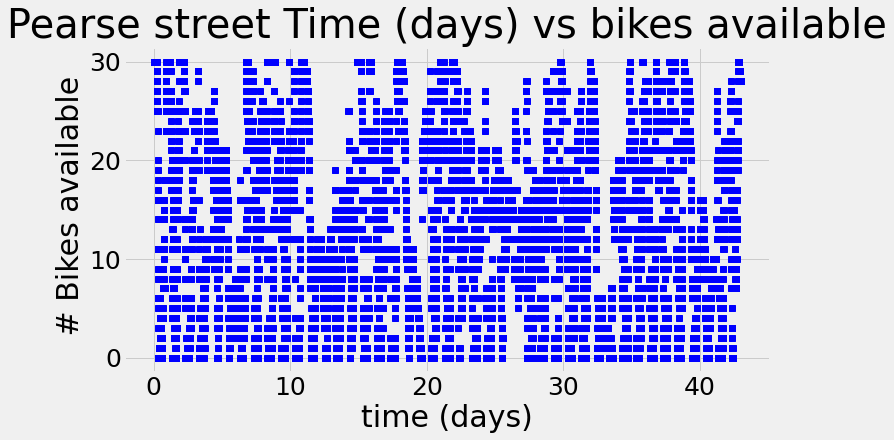

In [70]:
secondsPearse,dt = convertDays(pearse)

plt.plot(secondsPearse,pearse.iloc[:,1],'s',color='b')
plt.rcParams['figure.figsize']=[30,10]
plt.title("Pearse street Time (days) vs bikes available",size=40)
plt.xlabel('time (days)',size=30)
plt.ylabel(' # Bikes available',size='30')
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)
#print(secondsPearse)

pearse.head()

pearse['days'] = secondsPearse.tolist()

In [20]:
pearse

,TIME,AVAILABLE BIKES,dataType,days
0,2020-01-28 00:00:02,30,wday,0.000000
1,2020-01-28 00:05:02,30,wday,0.003472
2,2020-01-28 00:10:02,30,wday,0.006944
3,2020-01-28 00:15:02,30,wday,0.010417
4,2020-01-28 00:20:02,30,wday,0.013889
...,...,...,...,...
12379,2020-03-10 23:35:02,29,wday,42.982639
12380,2020-03-10 23:40:02,28,wday,42.986111
12381,2020-03-10 23:45:02,28,wday,42.989583
12382,2020-03-10 23:50:02,28,wday,42.993056


want to be  able to crosss evaluate the results at the samee time as testing q x3 
want to ddo is change to do the cross evaluation of all the q values here in one function 
try include for all of the values of q so can plot onm one graph the different parametes 
if not get it to return the values 

In [6]:
result = pearse.copy()

max_value = pearse.iloc[:,1].max()
min_value = pearse.iloc[:,1].min()
result.iloc[:,1] = (pearse.iloc[:,1]- min_value) / (max_value - min_value)



In [64]:
result

,TIME,AVAILABLE BIKES,dataType,days
0,2020-01-28 00:00:02,1.000000,wday,0.000000
1,2020-01-28 00:05:02,1.000000,wday,0.003472
2,2020-01-28 00:10:02,1.000000,wday,0.006944
3,2020-01-28 00:15:02,1.000000,wday,0.010417
4,2020-01-28 00:20:02,1.000000,wday,0.013889
...,...,...,...,...
12379,2020-03-10 23:35:02,0.966667,wday,42.982639
12380,2020-03-10 23:40:02,0.933333,wday,42.986111
12381,2020-03-10 23:45:02,0.933333,wday,42.989583
12382,2020-03-10 23:50:02,0.933333,wday,42.993056


In [71]:
q=[2,6,12]
stride = 1
lag = 3
#y =result.iloc[:,1]
y= pearse.iloc[:,1]
t=pearse.iloc[:,3]
alphaRange = [0.0001,0.001,0.005,0.01,.1] 

In [72]:
def combinedTest(y,t,q):
    w=math.floor(7*24*60*60/dt) # number of samples per week
    len =y.size-w-lag*w-q
    XX=y[q:q+len:stride]


    for i in range(1,lag):
        X=y[i*w+q:i*w+q+len:stride]
        XX=np.column_stack((XX,X))

    d=math.floor(24*60*60/dt) # number of samples per day

    for i in range(0,lag):
        X=y[i*d+q:i*d+q+len:stride]
        XX=np.column_stack((XX,X))

    for i in range(0,lag):
        X=y[i:i+len:stride]
        XX=np.column_stack((XX,X))

    yy=y[lag*w+w+q:lag*w+w+q+len:stride]
    tt=t[lag*w+w+q:lag*w+w+q+len:stride]
    X_df  = pd.DataFrame(XX)
    Y_df = pd.DataFrame(yy.values)
  
    mse,STD = crossEval(alphaRange,X_df,Y_df)
    print("q is ",q,"mse",mse)
    print("q is ",q,"std",STD)
    return mse,STD

"""
    X_df  = pd.DataFrame(XX)
    Y_df = pd.DataFrame(yy.values)
  
    mse,STD = crossEval(alphaRange,X_df,Y_df)
    print("q is ",q,"mse",mse)
    print("q is ",q,"std",STD)
    return mse,STD
 yy.reset_index(drop=True,inplace=True)
    tt.reset_index(drop=True,inplace=True)

    return XX,yy,tt

"""

   

'\n    X_df  = pd.DataFrame(XX)\n    Y_df = pd.DataFrame(yy.values)\n  \n    mse,STD = crossEval(alphaRange,X_df,Y_df)\n    print("q is ",q,"mse",mse)\n    print("q is ",q,"std",STD)\n    return mse,STD\n yy.reset_index(drop=True,inplace=True)\n    tt.reset_index(drop=True,inplace=True)\n\n    return XX,yy,tt\n\n'

In [208]:
XX,YY,TT =combinedTest(y,t,2)

In [209]:
TT

0       28.006944
1       28.010417
2       28.013889
3       28.017361
4       28.020833
          ...    
4313    42.982639
4314    42.986111
4315    42.989583
4316    42.993056
4317    42.996528
Name: days, Length: 4318, dtype: float64

In [73]:
def crossEval(alpha,xDF,yDF):
    train, test = train_test_split(np.arange(0,yDF.shape[0]),test_size=0.2)
    MSE =[]
    meanE=[];stdE=[]
    cv = TimeSeriesSplit(n_splits=5)
    for a in alpha:
        for train,test in cv.split(xDF):
          model =Ridge(fit_intercept=False,alpha=1/(2*a)).fit(xDF.iloc[train],yDF.iloc[train])
          yPred = model.predict(xDF.iloc[test])
          MSE.append(mean_squared_error(yPred,yDF.iloc[test]))
       
        meanE.append(np.array(np.sqrt(MSE)).mean())
        stdE.append(np.array(np.sqrt(MSE)).std())
       # print("the mse",meanE,"std",stdE)
    return meanE,stdE

In [40]:
def printCrossEval(m10,std10,m30,std30,m1,std1,alpha,TITLE):
    plt.title(TITLE,size=35)
    plt.rcParams['figure.figsize']=[10,6]
    plt.xlabel("C",size=20)
    plt.ylabel(" MSE ",size=20)
    plt.errorbar(alpha,m10,yerr=std10,fmt="-o",ecolor="r",capsize=5)
    plt.errorbar(alpha,m30,yerr=std30,fmt="-o",ecolor="b",capsize=8)
    plt.errorbar(alpha,m1,yerr=std1,fmt="-o",ecolor="g",capsize=10)
    plt.legend(["10 Min prediction","30 Min Prediction","1 hour Prediction"],loc='upper right',fontsize=10)



In [66]:
def printCrossEval2(m10,std10,m30,std30,m1,std1,m,m2,m3,alpha,TITLE):
    plt.title(TITLE,size=35)
    plt.rcParams['figure.figsize']=[10,6]
    plt.xlabel("C",size=20)
    plt.ylabel(" MSE ",size=20)
    plt.errorbar(alpha,m10,yerr=std10,fmt="-o",ecolor="r",capsize=5)
    plt.errorbar(alpha,m30,yerr=std30,fmt="-o",ecolor="b",capsize=8)
    plt.errorbar(alpha,m1,yerr=std1,fmt="-o",ecolor="g",capsize=10)
    plt.errorbar(alpha,m,fmt="-o",ecolor="r",capsize=5)
    plt.errorbar(alpha,m1,fmt="-o",ecolor="b",capsize=8)
    plt.errorbar(alpha,m2,fmt="-o",ecolor="g",capsize=10)
    plt.legend(["10m test predictions","30m test predictions","1h test predictions","10m train predictions","30m train predictions","1h train predictions "],loc='upper right',fontsize=15)



q is  2 mse [5.729168226862257, 5.738876663368578, 5.743457308380767, 5.745885296091882]
q is  2 std [0.49738191798131803, 0.5168349939689446, 0.524310854439156, 0.5281088614583631]
q is  6 mse [5.713787741461883, 5.730108107674601, 5.737555473436246, 5.741481390510532]
q is  6 std [0.5336904035914981, 0.5469757679671552, 0.5518998532646044, 0.5543732171045592]
q is  12 mse [5.7225252326520035, 5.7407007482175185, 5.748877861088122, 5.753182216851546]
q is  12 std [0.530621384640049, 0.541246685507002, 0.5451531755104839, 0.547099761287679]


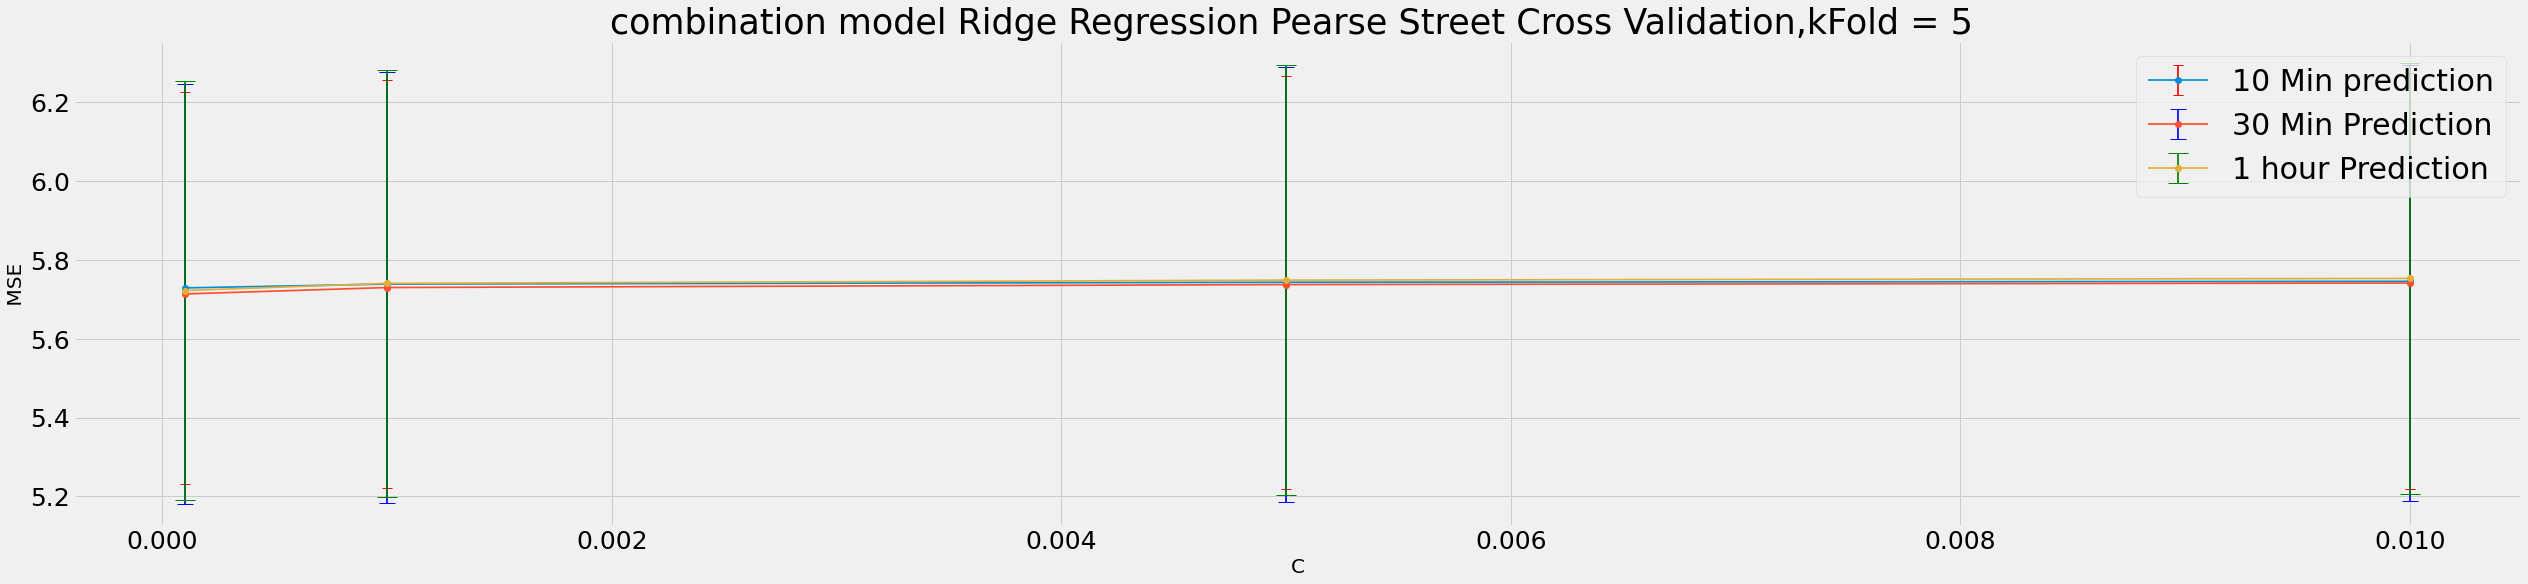

In [13]:
m10,std10=combinedTest(y,t,2)
m30,std30= combinedTest(y,t,6)
m1,std1 = combinedTest(y,t,12)
title = "combination model Ridge Regression Pearse Street Cross Validation,kFold = 5 "




In [74]:
## look at different trends 
def testPredictions(q,dd,lag,t,y):
    ## Replace this part for  other traing and 
    stride = 1 
    XX = y[0:y.size-q-lag*dd:stride]
    MSE =[]
    for i in range(1,lag):
        X = y[i*dd:y.size-q-(lag-i)*dd:stride]
        XX = np.column_stack((XX,X))
    yy = y[lag*dd+q::stride]
    tt=t[lag*dd+q::stride]
    ytrue = y[lag*dd+q::stride]

    train, test = train_test_split(np.arange(lag*dd+q,yy.size),test_size=0.2,shuffle=False)
    model = Ridge(fit_intercept=False).fit(XX[train],yy[train])
    print(model.intercept_,model.coef_)

    yPred = model.predict(XX[test])
    MSE.append(mean_squared_error(yPred,yy[test]))
    print("Q :",q, "mse:" ,np.array(MSE).mean()  )


In [90]:
lag=3; q=2
stride=1
MSE=[]  
w=math.floor(7*24*60*60/dt) # number of samples per week
len =y.size-w-lag*w-q
XX=y[q:q+len:stride]
for i in range(1,lag):
    X=y[i*w+q:i*w+q+len:stride]
    XX=np.column_stack((XX,X))

d=math.floor(24*60*60/dt) # number of samples per day

for i in range(0,lag):
    X=y[i*d+q:i*d+q+len:stride]
    XX=np.column_stack((XX,X))

for i in range(0,lag):
    X=y[i:i+len:stride]
    XX=np.column_stack((XX,X))

yy=y[lag*w+w+q:lag*w+w+q+len:stride]
tt=t[lag*w+w+q:lag*w+w+q+len:stride]


X_df  = pd.DataFrame(XX)
Y_df = pd.DataFrame(yy.values)
    
train, test = train_test_split(np.arange(0,Y_df.shape[0]),test_size=0.2)



model = Ridge(fit_intercept=False).fit(X_df.iloc[train],Y_df.iloc[train])
yPred =np.rint(model.predict(X_df.iloc[test]))
MSE.append(mean_squared_error(yPred,Y_df.iloc[test]))
print("Q :",q, "mse:" ,np.array(MSE).mean())

Q : 2 mse: 24.74189814814815


In [86]:
yPred

array([[14.],
       [17.],
       [19.],
       [14.],
       [ 7.],
       [27.],
       [16.],
       [ 5.],
       [ 9.],
       [25.],
       [ 3.],
       [ 4.],
       [ 8.],
       [22.],
       [22.],
       [ 5.],
       [ 7.],
       [11.],
       [ 1.],
       [10.],
       [ 6.],
       [ 5.],
       [19.],
       [ 2.],
       [ 2.],
       [21.],
       [27.],
       [23.],
       [-0.],
       [14.],
       [11.],
       [-2.],
       [ 2.],
       [ 4.],
       [23.],
       [25.],
       [11.],
       [ 5.],
       [ 5.],
       [ 8.],
       [14.],
       [26.],
       [22.],
       [22.],
       [ 9.],
       [ 2.],
       [ 1.],
       [12.],
       [19.],
       [19.],
       [10.],
       [21.],
       [16.],
       [ 3.],
       [ 5.],
       [ 3.],
       [19.],
       [ 2.],
       [ 5.],
       [20.],
       [ 3.],
       [ 5.],
       [21.],
       [23.],
       [ 0.],
       [28.],
       [25.],
       [11.],
       [13.],
       [16.],
       [ 9.],
      

In [75]:
print("Predictions in 10 minutes short term trends ")
testPredictions(q=2,dd=1,lag=3,t=t,y=y)
d= math.floor(24*60*60/dt)
print("Predictions 10 minutes ahead using daily seasonality")
testPredictions(q=2,dd=d,lag=3,t=t,y=y)
print("Weekly seasonality 10 mins ahead ")

print("Predictions in 10 minutes using weekly seasonality")
w= math.floor(7*24*60*60/dt)
testPredictions(q=2,dd=w,lag=3,t=t,y=y)

Predictions in 10 minutes short term trends 
0.0 [ 9.99940026e-01  7.14819933e-05 -1.17304400e-05]
Q : 2 mse: 6.891242076012253e-09
Predictions 10 minutes ahead using daily seasonality
0.0 [9.99998341e-01 7.80309200e-07 7.47201837e-07]
Q : 2 mse: 1.9172458768447231e-10
Weekly seasonality 10 mins ahead 
Predictions in 10 minutes using weekly seasonality
0.0 [9.99837340e-01 5.82717243e-05 1.51065863e-04]
Q : 2 mse: 1.3376724875913151e-06


In [82]:
t

0         0.000000
1         0.003472
2         0.006944
3         0.010417
4         0.013889
           ...    
12379    42.982639
12380    42.986111
12381    42.989583
12382    42.993056
12383    42.996528
Name: days, Length: 12384, dtype: float64

In [18]:
print("Predictions in 30 minutes short term trends ")
testPredictions(q=6,dd=1,lag=3,t=t,y=y)
print("Predictions 30 minutes ahead using daily seasonality")
testPredictions(q=6,dd=d,lag=3,t=t,y=y)

print("Predictions in 30Min using weekly seasonality")
testPredictions(q=6,dd=w,lag=3,t=t,y=y)

Predictions in 30 minutes short term trends 
0.0 [ 9.99939991e-01  7.15401094e-05 -1.17539035e-05]
Q : 6 mse: 6.916264774834734e-09
Predictions 30 minutes ahead using daily seasonality
0.0 [9.99998341e-01 7.80069549e-07 7.47332886e-07]
Q : 6 mse: 1.9186431947152812e-10
Predictions in 30Min using weekly seasonality
0.0 [9.99829108e-01 6.20787987e-05 1.59840591e-04]
Q : 6 mse: 1.734171491758602e-06


In [20]:
y

0        30
1        30
2        30
3        30
4        30
         ..
12379    29
12380    28
12381    28
12382    28
12383    28
Name: AVAILABLE BIKES, Length: 12384, dtype: int64

In [76]:
### ALL USING WEEKLY
print("Predictions in 10min weekly")
testPredictions(q=2,dd=w,lag=3,t=t,y=y)
print("Predictions 30 mins weekly")
testPredictions(q=6,dd=w,lag=3,t=t,y=y)

print("Predictions in 1hour using weekly seasonality")
testPredictions(q=12,dd=w,lag=3,t=t,y=y)

Predictions in 10min weekly
0.0 [9.99837340e-01 5.82717243e-05 1.51065863e-04]
Q : 2 mse: 1.3376724875913151e-06
Predictions 30 mins weekly
0.0 [9.99829108e-01 6.20787987e-05 1.59840591e-04]
Q : 6 mse: 1.734171491758602e-06
Predictions in 1hour using weekly seasonality
0.0 [9.99824977e-01 6.43949054e-05 1.64224930e-04]
Q : 12 mse: 2.0431788160859654e-06


In [32]:
print("Predictions in 1hour short term trends ")
testPredictions(q=12,dd=1,lag=3,t=t,y=y)
print("Predictions 1 hour ahead using daily seasonality")
testPredictions(q=12,dd=d,lag=3,t=t,y=y)

print("Predictions in 30Min using weekly seasonality")
testPredictions(q=12,dd=w,lag=3,t=t,y=y)

Predictions in 1hour short term trends 
0.0 [ 0.95211196  0.05396811 -0.00626572]
Q : 12 mse: 4.893745671829468e-06
Predictions 1 hour ahead using daily seasonality
0.0 [9.98509507e-01 6.99991994e-04 6.71361361e-04]
Q : 12 mse: 1.7206701150740086e-07
Predictions in 30Min using weekly seasonality
0.0 [0.87999845 0.04901131 0.10702075]
Q : 12 mse: 0.0010008349513192338


Need to do cross eval for weekly data as results in the lowest error 

In [62]:
def crossEval2(q,dd,lag,y,t):
  stride = 1  
  XX = y[0:y.size-q-lag*dd:stride]
  MSE =[]
  for i in range(1,lag):
      X = y[i*dd:y.size-q-(lag-i)*dd:stride]
      XX = np.column_stack((XX,X))
  yy = y[lag*dd+q::stride]
  tt=t[lag*dd+q::stride]
  ytrue = y[lag*dd+q::stride]


  train, test = train_test_split(np.arange(lag*dd+q,yy.size),test_size=0.2,shuffle=False)
  MSE =[] ;m=[]
  meanE=[];stdE=[];temp=[]
  cv = TimeSeriesSplit(n_splits=5)
  for a in alphaRange:
      #for train,test in cv.split(XX):
      model =Ridge(fit_intercept=False,alpha=1/(2*a)).fit(XX[train],yy[train])
      yPred = model.predict(XX[test])
      yTraining = model.predict(XX[train])
      MSE.append(mean_squared_error(yPred,yy[test]))
      temp.append(mean_squared_error(yTraining,yy[train]))
      meanE.append(np.array(MSE).mean())
      stdE.append(np.array(MSE).std())
      m.append(np.array(temp).mean())
      
  return meanE,stdE,m

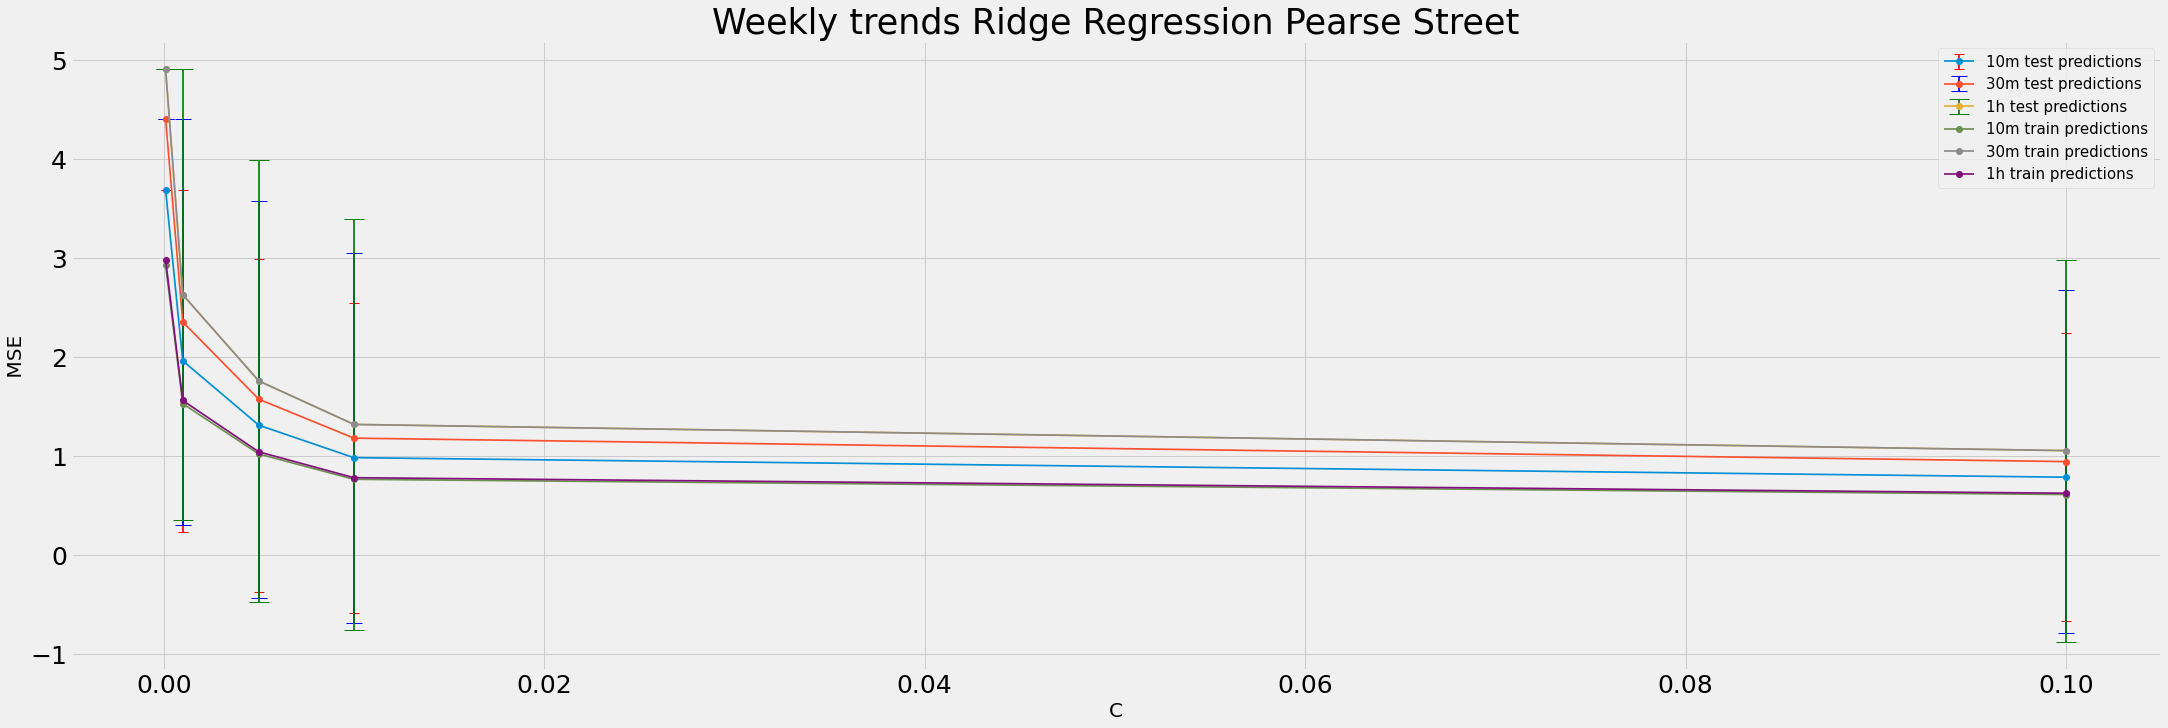

In [91]:
m10,std10,m=crossEval2(q=2,dd=w,lag=3,y=y,t=t)
m30,std30,m2= crossEval2(q=6,dd=w,lag=3,y=y,t=t)
m1,std1,m3= crossEval2(q=12,dd=w,lag=3,y=y,t=t)

title = "Weekly trends Ridge Regression Pearse Street"

printCrossEval2(m10,std10,m30,std30,m1,std1,m,m2,m3,alphaRange,title)

final model pearse 

In [92]:
## final model build 


def fModel(q,y,t):
    w=math.floor(7*24*60*60/dt) # number of samples per week
    len =y.size-w-lag*w-q
    XX=y[q:q+len:stride]


    for i in range(1,lag):
        X=y[i*w+q:i*w+q+len:stride]
        XX=np.column_stack((XX,X))

    d=math.floor(24*60*60/dt) # number of samples per day

    for i in range(0,lag):
        X=y[i*d+q:i*d+q+len:stride]
        XX=np.column_stack((XX,X))

    for i in range(0,lag):
        X=y[i:i+len:stride]
        XX=np.column_stack((XX,X))

    yy=y[lag*w+w+q:lag*w+w+q+len:stride]
    tt=t[lag*w+w+q:lag*w+w+q+len:stride]
    X_df  = pd.DataFrame(XX)
    Y_df = pd.DataFrame(yy.values)

    train, test = train_test_split(np.arange(0,Y_df.shape[0]),test_size=0.2)
    model =Ridge(fit_intercept=False,alpha=1/(2*0.02)).fit(X_df.iloc[train],Y_df.iloc[train])

    yPred = model.predict(XX)

    return t,y,tt,yPred

0.0 [0.39071093 0.39303988 0.14275347]
0.0 [0.35966634 0.35805352 0.18901606]
0.0 [0.37938561 0.38372813 0.15781355]


C:\Users\brosn\AppData\Local\Temp/ipykernel_28076/4226176661.py:63: UserWarning: Attempting to set identical left == right == 32 results in singular transformations; automatically expanding.
  plt.xlim((4*7+4,4*8))


<function matplotlib.pyplot.show(close=None, block=None)>

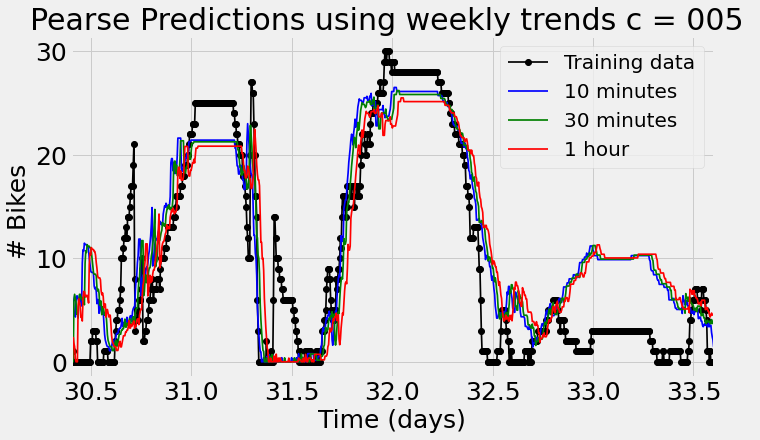

In [93]:
### IF USING WEEKLY 
stride = 1 
q=2
dd=math.floor(7*24*60*60/dt)
XX = y[0:y.size-q-lag*dd:stride]

for i in range(1,lag):
    X = y[i*dd:y.size-q-(lag-i)*dd:stride]
    XX = np.column_stack((XX,X))
yy = y[lag*dd+q::stride]
tt=t[lag*dd+q::stride]

#train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)
model =Ridge(fit_intercept=False,alpha=1/(2*0.1)).fit(XX,yy)
print(model.intercept_,model.coef_)

yPred = model.predict(XX)


q=12
dd=math.floor(7*24*60*60/dt)
XX1 = y[0:y.size-q-lag*dd:stride]

for i in range(1,lag):
    X = y[i*dd:y.size-q-(lag-i)*dd:stride]
    XX1 = np.column_stack((XX1,X))
yy1 = y[lag*dd+q::stride]
tt1=t[lag*dd+q::stride]

#train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)
model = Ridge(fit_intercept=False,alpha=1/(2*0.1)).fit(XX1,yy1)
print(model.intercept_,model.coef_)
yPred1 = model.predict(XX1)


q=6
dd=math.floor(7*24*60*60/dt)
XX2 = y[0:y.size-q-lag*dd:stride]

for i in range(1,lag):
    X = y[i*dd:y.size-q-(lag-i)*dd:stride]
    XX2 = np.column_stack((XX2,X))
yy2 = y[lag*dd+q::stride]
tt2=t[lag*dd+q::stride]

#train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

model = Ridge(fit_intercept=False,alpha=1/(2*0.1)).fit(XX2,yy2)
print(model.intercept_,model.coef_)

yPred2 = model.predict(XX2)
## GIVES MOST OF ITS IMPORTANCE TO THE LAST POINT 
plt.plot(t,y,'-o',color='black')
plt.plot(tt,yPred,color='blue')
plt.plot(tt2,yPred2,color='green')
plt.plot(tt1,yPred1,color='red')
plt.title("Pearse Predictions using weekly trends c = 005 ",size=30)
plt.rcParams['figure.figsize']=[18,8]
plt.xlabel('Time (days)',size=25)
plt.ylabel("# Bikes ",size=25)
plt.legend(["Training data","10 minutes","30 minutes","1 hour"],loc='upper right',fontsize=20)
day = math .floor(24*60*60/dt) ## number of samples per day
plt.xlim((4*7+4,4*8))
plt.show

0.0 [9.99187752e-01 2.91177078e-04 7.54155735e-04]
Vlaue for mse  50.964277726562095
0.0 [9.99214057e-01 2.76865075e-04 7.25247186e-04]
The mean squared error for q=12  62.96965032198704
0.0 [9.99201514e-01 2.82579294e-04 7.40477165e-04]
The mean squared error for q=6  54.475065651666874


C:\Users\brosn\AppData\Local\Temp/ipykernel_28076/3344093064.py:67: UserWarning: Attempting to set identical left == right == 32 results in singular transformations; automatically expanding.
  plt.xlim((4*7+4,4*8))


<function matplotlib.pyplot.show(close=None, block=None)>

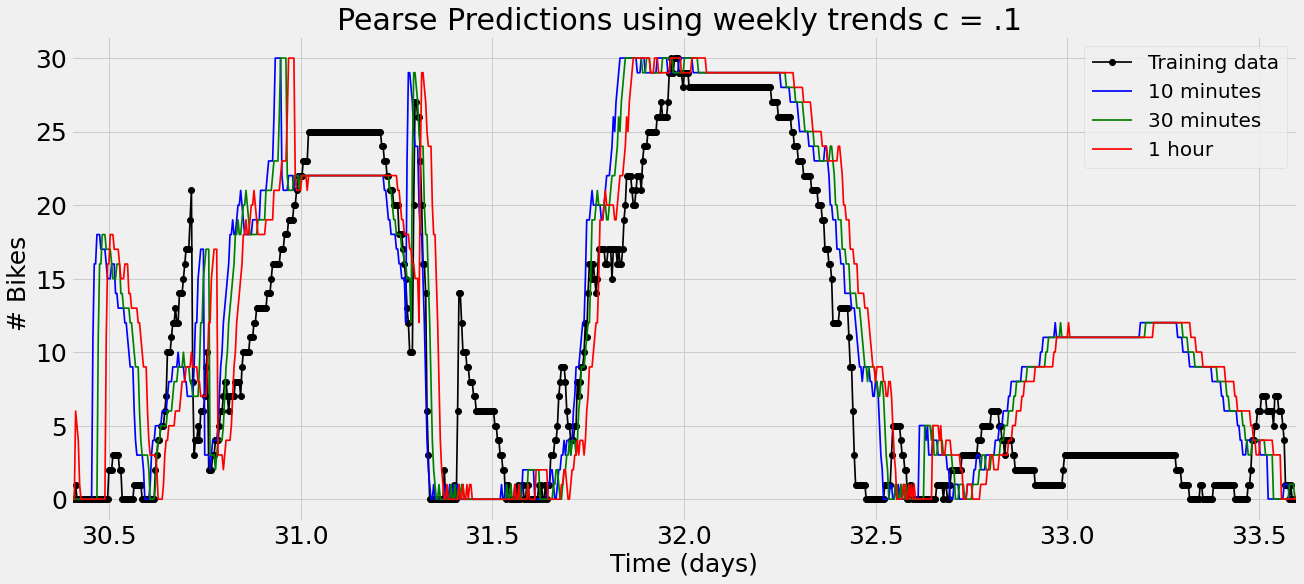

In [94]:
### IF USING WEEKLY 
stride = 1 
q=2
dd=math.floor(7*24*60*60/dt)
XX = y[0:y.size-q-lag*dd:stride]

for i in range(1,lag):
    X = y[i*dd:y.size-q-(lag-i)*dd:stride]
    XX = np.column_stack((XX,X))
yy = y[lag*dd+q::stride]
tt=t[lag*dd+q::stride]

train, test = train_test_split(np.arange(lag*dd+q,yy.size),test_size=0.2,shuffle=False)
model = Ridge(fit_intercept=False,alpha=1/(2*0.1)).fit(XX[train],yy[train])

print(model.intercept_,model.coef_)

yPred = model.predict(XX)
mse=mean_squared_error(yy,yPred)
print("Vlaue for mse ",mse)
q=12
dd=math.floor(7*24*60*60/dt)
XX1 = y[0:y.size-q-lag*dd:stride]

for i in range(1,lag):
    X = y[i*dd:y.size-q-(lag-i)*dd:stride]
    XX1 = np.column_stack((XX1,X))
yy1 = y[lag*dd+q::stride]
tt1=t[lag*dd+q::stride]

train, test = train_test_split(np.arange(lag*dd+q,yy.size),test_size=0.2,shuffle=False)
model = Ridge(fit_intercept=False,alpha=1/(2*0.1)).fit(XX1[train],yy1[train])
print(model.intercept_,model.coef_)
yPred1 = model.predict(XX1)
mse=mean_squared_error(yy1,yPred1)
print("The mean squared error for q=12 ",mse)

q=6
dd=math.floor(7*24*60*60/dt)
XX2 = y[0:y.size-q-lag*dd:stride]

for i in range(1,lag):
    X = y[i*dd:y.size-q-(lag-i)*dd:stride]
    XX2 = np.column_stack((XX2,X))
yy2 = y[lag*dd+q::stride]
tt2=t[lag*dd+q::stride]

train, test = train_test_split(np.arange(lag*dd+q,yy.size),test_size=0.2,shuffle=False)

model = Ridge(fit_intercept=False,alpha=1/(2*0.1)).fit(XX2[train],yy2[train])
print(model.intercept_,model.coef_)

yPred2 = model.predict(XX2)
mse=mean_squared_error(yy2,yPred2)
print("The mean squared error for q=6 ",mse)
## GIVES MOST OF ITS IMPORTANCE TO THE LAST POINT 
plt.plot(t,y,'-o',color='black')
plt.plot(tt,yPred,color='blue')
plt.plot(tt2,yPred2,color='green')
plt.plot(tt1,yPred1,color='red')
plt.title("Pearse Predictions using weekly trends c = .1 ",size=30)
plt.rcParams['figure.figsize']=[18,8]
plt.xlabel('Time (days)',size=25)
plt.ylabel("# Bikes ",size=25)
plt.legend(["Training data","10 minutes","30 minutes","1 hour"],loc='upper right',fontsize=20)
day = math .floor(24*60*60/dt) ## number of samples per day
plt.xlim((4*7+4,4*8))
plt.show

In [95]:
def BuildModel(q,y,t):
    lag=3
    stride=1
    q=6
    w=math.floor(7*24*60*60/dt) # number of samples per week
    len =y.size-w-lag*w-q
    XX=y[q:q+len:stride]
    for i in range(1,lag):
        X=y[i*w+q:i*w+q+len:stride]
        XX=np.column_stack((XX,X))

    d=math.floor(24*60*60/dt) # number of samples per day

    for i in range(0,lag):
        X=y[i*d+q:i*d+q+len:stride]
        XX=np.column_stack((XX,X))

    for i in range(0,lag):
        X=y[i:i+len:stride]
        XX=np.column_stack((XX,X))

    yy=y[lag*w+w+q:lag*w+w+q+len:stride]
    tt=t[lag*w+w+q:lag*w+w+q+len:stride]

    yy.reset_index(drop=True, inplace=True)
    tt.reset_index(drop=True, inplace=True)
    return tt,yy,XX

ValueError: x and y must have same first dimension, but have shapes (6330,) and (4314,)

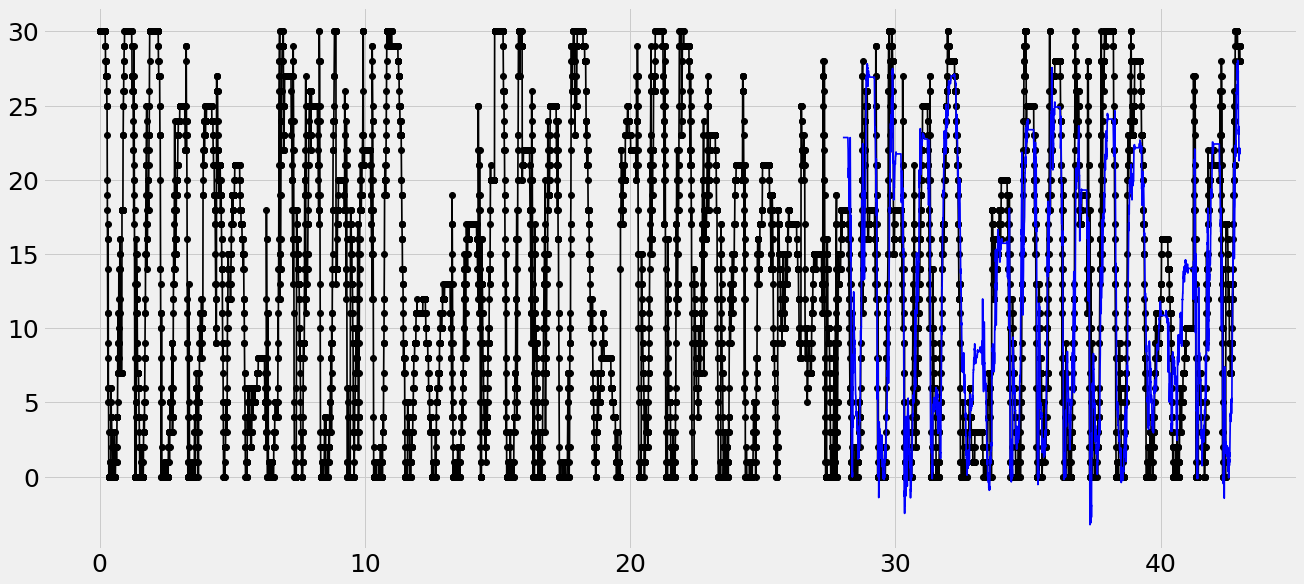

In [96]:
tt,yy,XX = BuildModel(2,y,t)
train, test = train_test_split(np.arange(0,yy.size),test_size=0.2) 
model = Ridge(fit_intercept=False,alpha=1/(2*0.005)).fit(XX[train],yy[train])
yPred = model.predict(XX)

tt1,yy,XX = BuildModel(6,y,t)
train, test = train_test_split(np.arange(0,yy.size),test_size=0.2) 
model = Ridge(fit_intercept=False,alpha=1/(2*0.005)).fit(XX[train],yy[train])
yPred1 = model.predict(XX)

tt,yy,XX = BuildModel(12,y,t)
train, test = train_test_split(np.arange(0,yy.size),test_size=0.2) 
model = Ridge(fit_intercept=False,alpha=1/(2*0.005)).fit(XX[train],yy[train])
yPred2 = model.predict(XX)



plt.plot(t,y,'-o',color='black')
plt.plot(tt,yPred,color='blue')
plt.plot(tt2,yPred2,color='green')
plt.plot(tt1,yPred1,color='red')
plt.title("Pearse Predictions using weekly trends c = 005 ",size=30)
plt.rcParams['figure.figsize']=[18,8]
plt.xlabel('Time (days)',size=25)
plt.ylabel("# Bikes ",size=25)
plt.legend(["Training data","10 minutes","30 minutes","1 hour"],loc='upper right',fontsize=20)
day = math .floor(24*60*60/dt) ## number of samples per day
plt.xlim((4*7+4,4*8))
plt.show

In [ ]:
stride = 1 
q=2
dd=math.floor(7*24*60*60/dt)
XX = y[0:y.size-q-lag*dd:stride]

for i in range(1,lag):
    X = y[i*dd:y.size-q-(lag-i)*dd:stride]
    XX = np.column_stack((XX,X))
yy = y[lag*dd+q::stride]
tt=t[lag*dd+q::stride]

train, test = train_test_split(np.arange(lag*dd+q,yy.size),test_size=0.2,shuffle=False)
model = Ridge(fit_intercept=False,alpha=1/(2*0.005)).fit(XX[train],yy[train])
print(model.intercept_,model.coef_)

yPred = model.predict(XX)


q=12
dd=math.floor(7*24*60*60/dt)
XX1 = y[0:y.size-q-lag*dd:stride]

for i in range(1,lag):
    X = y[i*dd:y.size-q-(lag-i)*dd:stride]
    XX1 = np.column_stack((XX1,X))
yy1 = y[lag*dd+q::stride]
tt1=t[lag*dd+q::stride]

train, test = train_test_split(np.arange(lag*dd+q,yy.size),test_size=0.2,shuffle=False)
model = Ridge(fit_intercept=False,alpha=1/(2*0.005)).fit(XX1[train],yy1[train])
print(model.intercept_,model.coef_)
yPred1 = model.predict(XX1)


q=6
dd=math.floor(7*24*60*60/dt)
XX2 = y[0:y.size-q-lag*dd:stride]

for i in range(1,lag):
    X = y[i*dd:y.size-q-(lag-i)*dd:stride]
    XX2 = np.column_stack((XX2,X))
yy2 = y[lag*dd+q::stride]
tt2=t[lag*dd+q::stride]

train, test = train_test_split(np.arange(lag*dd+q,yy.size),test_size=0.2,shuffle=False)

model = Ridge(fit_intercept=False,alpha=1/(2*0.005)).fit(XX2[train],yy2[train])
print(model.intercept_,model.coef_)

yPred2 = model.predict(XX2)
## GIVES MOST OF ITS IMPORTANCE TO THE LAST POINT 
plt.plot(t,y,'-o',color='black')
plt.plot(tt,yPred,color='blue')
plt.plot(tt2,yPred2,color='green')
plt.plot(tt1,yPred1,color='red')
plt.title("Pearse Predictions using weekly trends c = 005 ",size=30)
plt.rcParams['figure.figsize']=[18,8]
plt.xlabel('Time (days)',size=25)
plt.ylabel("# Bikes ",size=25)
plt.legend(["Training data","10 minutes","30 minutes","1 hour"],loc='upper right',fontsize=20)
day = math .floor(24*60*60/dt) ## number of samples per day
plt.xlim((4*7+4,4*8))
plt.show

In [145]:
def graphResults():
   t0,y0,tt1,yPred1= fModel(q=2,y=y,t=t)
   t0,y0,tt2,yPred2= fModel(q=6,y=y,t=t)
   t0,y0,tt3,yPred3= fModel(q=12,y=y,t=t)
     
   plt.plot(t0, y0,"-o", color='black')
   plt.plot(tt1, yPred1, color='blue')
   plt.plot(tt2, yPred2, color='red')
   plt.plot(tt3, yPred3, color='orange')
   plt.xlabel("time (days)"); 
   plt.ylabel(" #bikes ")
   plt.legend(["training data","predictions"],loc='upper right')
   day=math.floor(24*60*60/dt) # number of samples per day
   plt.xlim((4*7,4*7+4))
   plt.rcParams['figure.figsize']=[20,10]
   plt.show()




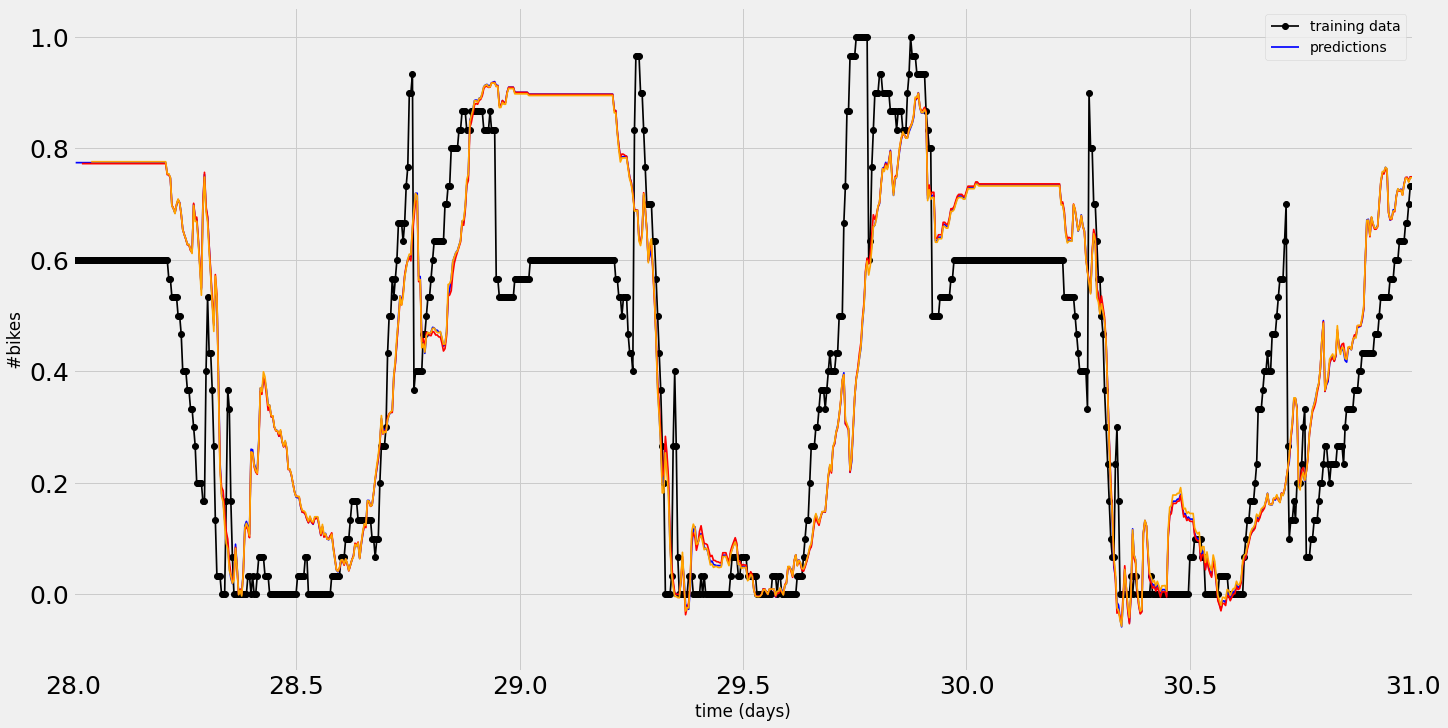

In [146]:
graphResults()

In [182]:
### IF USING WEEKLY 
stride = 1 
q=2
dd=math.floor(7*24*60*60/dt)
XX = y[0:y.size-q-lag*dd:stride]

for i in range(1,lag):
    X = y[i*dd:y.size-q-(lag-i)*dd:stride]
    XX = np.column_stack((XX,X))
yy = y[lag*dd+q::stride]
tt=t[lag*dd+q::stride]

train, test = train_test_split(np.arange(lag*dd+q,yy.size),test_size=0.2,shuffle=False)
